<a href="https://colab.research.google.com/github/RichardHarwood/3D_Unet_Plant_Roots/blob/main/3D_Unet_from_source.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note that 3D_Unet uses H5 Data to convert 3DTIFF (most likely format ) you need to run the following:


```
from skimage import io
import h5py

img=skimage.io.imread("path to raw tif")
mask=skimage.io.imread("path to mask tif")

hf = h5py.File("path to new .h5 file", 'w')
hf.create_dataset('raw', data=img)
hf.create_dataset('label', data=mask)
hf.close()
```

Note that "raw" and "label" correspond to the config files used to train the model and segment data

Step one load packages

In [1]:
!pip install wget
!pip install open3d
!pip install vedo
#!pip install stackview ipycanvas==0.11
import os
!git clone https://github.com/wolny/pytorch-3dunet.git
%cd pytorch-3dunet
!python setup.py install

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=b653eafbc6a8447fd26f028d92bfb1a42dd14db5b90640f3c620c68bf12f85d0
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.0 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Unin

Check that a gpu has been given, if response to below chunk is True it means training will be don on GPU, depending on the memory of your GPU you will need to change patch_size, stride_size and batch_size below. Essentially controlling the size of information that is fed into the model for a given run.



In [2]:
import torch
torch.cuda.is_available()

False

Next, we need to mount out google drive, a pop up window will appear and you just need to enter your details

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Next, we create a suite of folders, these should all be automated for this example (which pulls data from the cloud to train). If using your own data you could keep this folder structure and just drag in your own training data into the train, qc and test folders.

In [4]:
#need to set appropriate  home folder
import os.path
from os import path
if path.exists('/content/drive/MyDrive/3D_UNET/') == False:
  os.mkdir('/content/drive/MyDrive/3D_UNET/')
home_folder = "/content/drive/MyDrive/3D_UNET/"

In [5]:
#Create Config Folder
if path.exists(home_folder+'config_files') == False:
  os.mkdir(home_folder+'config_files')
config_folder = home_folder+'config_files/'

In [6]:
#Create Checkpoint Folder
if path.exists(home_folder+'checkpoint_dir') == False:
  os.mkdir(home_folder+'checkpoint_dir')
checkpoint_dir = home_folder+'checkpoint_dir/'

In [7]:
#Create Training_data Folder

if path.exists(home_folder+'training_data') == False:
  os.mkdir(home_folder+'training_data')

if path.exists(home_folder+'training_data/train/') == False:
  os.mkdir(home_folder+'training_data/train/')

if path.exists(home_folder+'training_data/qc/') == False:
  os.mkdir(home_folder+'training_data/qc/')

if path.exists(home_folder+'training_data/test/') == False:
  os.mkdir(home_folder+'training_data/test/')



**Download example training data**

Here we pull a small amount of data from zenodo that was used in the paper. It consists of 7 small crops from an imaging session at the microCT beamline at ANSTO. Of the seven images 1 is put aside to “test” 4 images for “train” and 2 images for “qc”.


In [8]:
import wget
#wget.download("https://zenodo.org/records/4766931/files/"+"E camaldulensis - Cropped.tif"+"?download=1", out='/content/drive/MyDrive/3D_UNET/download_data/euc.tif')
#Test Data
wget.download("https://zenodo.org/records/13932420/files/"+"recon_sub__073_corn_pcv_ww_R5_wb_1x_stitch_6.tif_003.h5"+"?download=1", out=home_folder+'training_data/test/img_76.h5')
#Train Data
wget.download("https://zenodo.org/records/13932420/files/"+"recon_sub__074_wheat_pcv_6days_R1_wb_1x_stitch.tif_022.h5"+"?download=1", out=home_folder+'training_data/train/img_74.h5')
wget.download("https://zenodo.org/records/13932420/files/"+"recon_sub__078_corn_pvc_2days_R3_wb_1x_stitch.tif_002.h5"+"?download=1", out=home_folder+'training_data/train/img_78.h5')
wget.download("https://zenodo.org/records/13932420/files/"+"recon_sub__079_corn_pvc_ww_R1_wb_1x_stitch.tif_002.h5"+"?download=1", out=home_folder+'training_data/train/img_79.h5')
wget.download("https://zenodo.org/records/13932420/files/"+"recon_sub__095_corn_pvc_4days_R1_wb_1x_stitch.tif_031.h5"+"?download=1", out=home_folder+'training_data/train/img_95.h5')
#QC Data
wget.download("https://zenodo.org/records/13932420/files/"+"recon_sub__103_wheat_pvc_4days_R3_wb_1x_stitch.tif_011.h5"+"?download=1", out=home_folder+'training_data/qc/img_103.h5')
wget.download("https://zenodo.org/records/13932420/files/"+"recon_sub__104_wheat_pvc_ww_R5_wb_1x_stitch.tif_002.h5"+"?download=1", out=home_folder+'training_data/qc/img_104.h5')


'/content/drive/MyDrive/3D_UNET/training_data/qc/img_104 (1).h5'

**Lets look at the training data**

(well one random training data set to understand the "raw" image and the "label" image)

**Note:** This example is just a 2D slice, you can change what slice you are looking at by changing the number in the [] brackets

For example



```
ax[0].imshow(image[270], cmap="gray");
```

would show slice 270 instead of slice 300

See the github readme for example renders of 3D traing data


In [9]:
import h5py
import numpy as np
hf=h5py.File(home_folder+'training_data/test/img_76.h5')
hf.keys()
raw_IMGs= hf['raw']
image=raw_IMGs[:]

label_IMGs= hf['label']
label=label_IMGs[:]


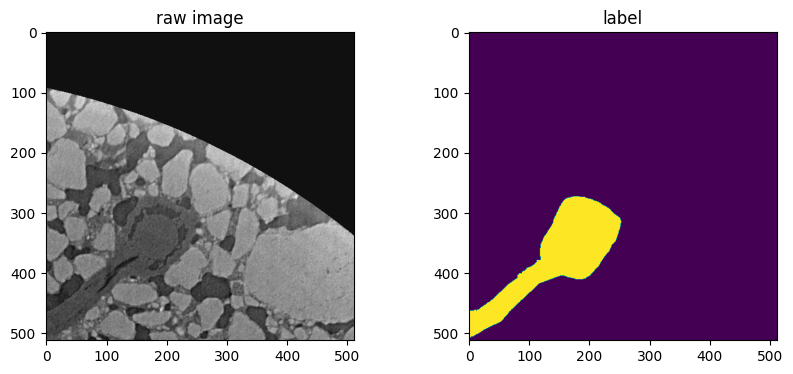

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=[10, 4]);
ax[0].imshow(image[300], cmap="gray");
ax[0].set_title('raw image');

ax[1].imshow(label[300]);
ax[1].set_title('label');

**Define Model Settings**

Realistically, for binary 3D segmentation all that needs to be changed here is batch_size, patch_shape and stride_shape, if you get a larger GPU these can increased. If you are using this beyond plant roots it can be valuable playing around with how much Z you capture, having a larger X Y patch and a smaller Z can improve performance if your target object in the Z isn’t too eradicate. For roots we keep a large Z patch because we want to capture the lateral roots.
In general the more epochs the better, the model will stop after not improving after a certain amount of validation runs (you can tweak “patience” to control that




In [9]:
model_name = "UNet3D"
in_channels = 1
out_channels= 1
layer_order = "gcr"
f_maps = [32,
          64,
          128,
          256]
num_groups = 8
final_sigmoid = True
is_segmentation = True
resume = None
pre_trained = None
validate_after_iters = 500
log_after_iters = 500
max_num_epochs = 10  ##Low for testing
max_num_iterations = 1800000
eval_score_higher_is_better = True
loss_name= 'BCEWithLogitsLoss'
learning_rate= 0.0002
weight_decay= 0.00001
eval_name= "MeanIoU"
lr_name= "ReduceLROnPlateau"
mode= 'max'
factor = 0.2
patience = 30
dataset= "StandardHDF5Dataset"
batch_size= 3  #important for gpu memory
num_workers= 2
raw_internal_path= "raw"
label_internal_path= "label"
weight_internal_path= None
################3
file_paths_train= home_folder+'training_data/train/'
######################
slice_builder_name= "SliceBuilder"
slice_builder_name_predict = "SliceBuilder"
patch_shape= [40, 170, 170]  #Change depending on GPU memory
stride_shape= [20, 40, 40]   #Change depending on GPU memory
halo_shape= [16, 32, 32]
threshold = 0.01
slack_acceptance = 0.01
name_transformer= "Standardize"
name_transformer_label= "BlobsToMask"
append_label= False
boundary= False
ToTensor_name = "ToTensor"
expand_dims_false= False
expand_dims_true= True
################
file_paths_val= home_folder+'training_data/qc/'
#####################
predictor_name='StandardPredictor'
#################################
file_paths_test= home_folder+'training_data/test/'
#############################
model_path=checkpoint_dir+"best_checkpoint.pytorch"

**Create the "train.yaml" file**

To run the model we create a .yaml file, essentially a structured text file. This means that every setting we used is logged and saved in the google drive (or hard drive)


In [10]:
# @title
#https://stackoverflow.com/questions/12470665/how-can-i-write-data-in-yaml-format-in-a-file
#https://stackoverflow.com/questions/59034564/yaml-dump-seeming-to-add-two-dashes-to-2nd-row-under-first-key


import yaml
train_intrem_config = {'model':{'name':model_name,
                                'in_channels':in_channels,
                                'out_channels':out_channels,
                                'layer_order':layer_order,
                                'f_maps':f_maps,
                                'num_groups':num_groups,
                                'final_sigmoid':final_sigmoid,
                                'is_segmentation':is_segmentation},
                       'trainer': {'checkpoint_dir':checkpoint_dir,
                                   'resume':resume,
                                   'pre_trained':pre_trained,
                                   'validate_after_iters':validate_after_iters,
                                   'log_after_iters':log_after_iters,
                                   'max_num_epochs':max_num_epochs,
                                   'max_num_iterations':max_num_iterations,
                                   'eval_score_higher_is_better':eval_score_higher_is_better},
                       'loss':{'name':loss_name},
                       'optimizer':{'learning_rate':learning_rate,
                                    'weight_decay':weight_decay},
                       'eval_metric':{'name':eval_name},
                       'lr_scheduler':{'name':lr_name,
                                       'mode':mode,
                                       'factor':factor,
                                       'patience':patience},
                       'loaders':{'dataset':dataset,
                                       'batch_size':batch_size,
                                       'num_workers':num_workers,
                                       'raw_internal_path':raw_internal_path,
                                       'label_internal_path':label_internal_path,
                                       'weight_internal_path':weight_internal_path,
                       'train':{'file_paths':[file_paths_train],"slice_builder":{'name':slice_builder_name,
                                                                               'patch_shape':patch_shape,
                                                                               'stride_shape':stride_shape,
                                                                               'threshold':threshold,
                                                                               'slack_acceptance':slack_acceptance},
                       'transformer': {"raw": [{"name":name_transformer},
                                               {"name":ToTensor_name,
                                                "expand_dims":expand_dims_true}],
                                       "label": [{"name":name_transformer_label,
                                                "append_label":append_label},
                                               {"name":ToTensor_name,
                                                "expand_dims":expand_dims_false}]}},
                       'val':{"file_paths":[file_paths_val],"slice_builder":{'name':slice_builder_name,
                                                                               'patch_shape':patch_shape,
                                                                               'stride_shape':patch_shape,
                                                                               'threshold':threshold,
                                                                               'slack_acceptance':slack_acceptance},
                       'transformer': {"raw": [{"name":name_transformer},
                                               {"name":ToTensor_name,
                                                "expand_dims":expand_dims_true}],
                                       "label": [{"name":name_transformer_label,
                                                  "append_label":append_label},
                                               {"name":ToTensor_name,
                                                "expand_dims":expand_dims_false}]}}}}

with open(config_folder+'model_train.yaml', 'w') as yaml_file:
    yaml.dump(train_intrem_config, yaml_file, default_flow_style=False, sort_keys=False)

 #print(yaml.dump(train_intrem_config, default_flow_style=False, sort_keys=False))

**Start Training**

To start training we run "train3dunet –config "path to train yaml" after an exclamation mark.  

the exclamation mark (!) allows users to run shell commands from inside a Jupyter Notebook code cell).

So to train we run

`!train3dunet --config /content/drive/MyDrive/3D_UNET/config_files/model_train.yaml`

**Note:** that this really depends on using the folder structure defined above.

**Note:** that if you don’t want to train (for example you have already trained a model and you want to segment data put a “#” in front of the text.



In [11]:
#!train3dunet --config /content/drive/MyDrive/3D_UNET/config_files/model_train.yaml

In [12]:
test_config_yaml ={
    "model_path": model_path,
    "model": {
        "name": model_name,
        "in_channels": in_channels,
        "out_channels": out_channels,
        "layer_order": layer_order,
        "f_maps": f_maps,
        "num_groups": num_groups,
        "final_sigmoid": final_sigmoid,
        "is_segmentation": is_segmentation
    },
    "predictor": {
        "name": predictor_name
    },
    "loaders": {
        "batch_size": batch_size,
        "raw_internal_path": raw_internal_path,
        "num_workers": num_workers,
        "test": {
            "file_paths": [
                file_paths_test
            ],
            "slice_builder": {
                "name": slice_builder_name_predict,
                "patch_shape": patch_shape,
                "stride_shape": patch_shape,
                "halo_shape": halo_shape
            },
            "transformer": {
                "raw": [
                    {
                        "name": name_transformer
                    },
                    {
                        "name": ToTensor_name,
                        "expand_dims": expand_dims_true
                    }
                ]
            }
        }
    }
}

with open(config_folder+'predict.yaml', 'w') as yaml_file:
    yaml.dump(test_config_yaml, yaml_file, default_flow_style=False, sort_keys=False)


In [13]:
#print(yaml.dump(test_config_yaml, default_flow_style=False, sort_keys=False))

**Start Predicting**

Currently this assumes we are using the model we trained above, if using a different model define “model_path” acconringly and if need be tweak any details of the test_config.yaml

The test_config.yaml will run the 3D-Unet model on every image in a folder, it will export out an image of confidence values for each voxel (0, the model thinks the voxel isn’t a root, higher values indicate more confidence the voxel is a root)

Running the sgemenation is the same as training the model

`!predict3dunet --config /content/drive/MyDrive/3D_UNET/config_files/predict.yaml`

The segmented files will have the same name but .prediction gets added to the end of the file name.





In [14]:
#!predict3dunet --config /content/drive/MyDrive/3D_UNET/config_files/predict.yaml

**Dealing with the output**
**Dealing with the output**
Now we have a folder with segmented image(s), in h5 format that we need to sort out.

To start we create a folder “processed” this is where our formatted output will go.

Below is one example of dealing with the direct model output. It involves using a threshold to create a binary image of the root (from the confidence values 3D image) then it removes small objects to omit voxels that shouldn’t be counted (e.g. organic matter). From this file a 3D mesh is created, and it can be viewed in the last chunk but copying and pasting the. stl file location.

The post processing steps will be dictated by how good your model is, how uniform your scans are, what GPU you can access (e.g. smaller patch sizes will create more issues)



In [15]:
import glob
import numpy as np
raw_data_path= file_paths_test
raw_file_names = [os.path.basename(x) for x in glob.glob(raw_data_path+"*.h5")]
raw_file_names = [e for e in raw_file_names if "predictions" in e ]
#################################
if path.exists(home_folder+'processed/') == False:
  os.mkdir(home_folder+'processed/')

file_paths_processed= home_folder+'processed/'
#########################
raw_file_names

[]

In [16]:
UNIQUE_ID =np.unique(raw_file_names)
len(UNIQUE_ID)

0

In [18]:

import h5py
import cv2
import skimage
from skimage.filters import threshold_otsu, threshold_yen
from skimage.measure import label
from skimage.morphology import remove_small_objects
from vedo import *
for i in UNIQUE_ID:
    print(i)
    hf=h5py.File(raw_data_path+i)
    hf.keys()
    dataset_IMGs= hf['predictions']
    image=dataset_IMGs[:]
    image=image[0,:,:,:]
    #image=zoom(image, (scale_factor,scale_factor, scale_factor), order=1)
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    thresh = threshold_yen(image)-45
    #thresh=20
    print (thresh)
    binary = image > thresh
    #binary=zoom(binary, (scale_factor,scale_factor, scale_factor), order=0)
    root_sml=label(binary)
    min_size_coef=2500 #trial and error really
    root_sml_obj = remove_small_objects(root_sml, min_size=min_size_coef, connectivity=2)
    root_sml_obj = (root_sml_obj != 0).astype(bool)

    root_VOL = Volume(root_sml_obj, spacing=((1),(1),(1)))
    root_ISO = root_VOL.isosurface(1)
    root_ISO.write(file_paths_processed+i+"__root.stl")
    skimage.io.imsave(file_paths_processed+i+"_processed.tif", root_sml_obj, check_contrast=False)

Now, to sanity check lets create a 3D model of the root system we just segmented using 3D-Unet

In [19]:
import open3d as o3d
import plotly.graph_objects as go
model_to_test="recon_sub__103_wheat_pvc_4days_R3_wb_1x_stitch.tif_014_predictions.h5__root.stl"
mesh = o3d.io.read_triangle_mesh(file_paths_processed+model_to_test)
if not mesh.has_vertex_normals(): mesh.compute_vertex_normals()
if not mesh.has_triangle_normals(): mesh.compute_triangle_normals()
triangles = np.asarray(mesh.triangles)
vertices = np.asarray(mesh.vertices)
colors = None

colors = (1.0, 0.0, 0.0)

fig = go.Figure(
    data=[
        go.Mesh3d(
            x=vertices[:,0],
            y=vertices[:,1],
            z=vertices[:,2],
            i=triangles[:,0],
            j=triangles[:,1],
            k=triangles[:,2],
            facecolor=colors,
            opacity=0.50)
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
)
fig.show()

[Open3D WARNING] Unable to load file /content/drive/MyDrive/3D_UNET/processed/recon_sub__103_wheat_pvc_4days_R3_wb_1x_stitch.tif_014_predictions.h5__root.stl with ASSIMP
